# Modelos Ocultos de Márkov 
# Ejemplo de Etiquetado en Texto

El algoritmo de Viterbi es un algoritmo dinámico ampliamente usado para estimar probabilidades de forma eficiente dentro de los Modelos Ocultos de Márkov. La idea general del algoritmo de Viterbi es realizar una búsqueda por caminos que sean altamente probables desde el principio, descartando aquellos caminos que tengan menos probabilidad. De esta forma, el algoritmo de Viterbi recorrerá únicamente los caminos que tengan la mayor probabilidad para cada uno de los posibles valores de las variables de emisiones $Y_t$, con $t=1,2,...,T$. Si bien esto no garantiza que se haya encontrado la probabilidad máxima global, si nos puede llevar hacia máximos locales que nos ayuden a resolver el problema.

En este notebook presentamos una implementación del algoritmo de Viterbi para realizar etiquetado de partes de la oración en texto. Esta es una tarea común en lingüística computacional que consiste en asignar a las palabras en un texto su categoría gramática; es decir, si son verbos, adjetivos, sustantivos, etcétera.

## Estimación del Modelo Oculto de Márkov

En primer lugar, haremos una estimación de las probabilidades que corresponden al Modelo Oculto Márkov que representará nuestro problema. Para esto, debemos obtener, a partir del texto, los valores de las observaciones y las emisiones; para hacer esto, definimos dos funciones que nos permitirán crear estos elementos. Como estamos trabajando con texto de lenguaje natural, nuestras observaciones y emisiones consistirán en vocabularios.

In [1]:
from collections import Counter, defaultdict
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

#Función que crea un vocabulario de palabras con un indice numérico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Función que pasa la cadena de símbolos a una secuencia con indices numéricos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc.strip().split()]

La idea es encontrar el modelo que sea capaz de mapear cadenas en un lenguaje $L_1$ a un lenguaje $L_2$. En este sentido, el primer lenguaje es el español y el segundo corresponde a las cadenas de etiquetas gramaticales. Explicamos a continuación en qué consisten estas etiquetas:

1. <b>DA</b>: Refiere a un Determinante Artículo, es decir, a aquellas palabras como 'el', 'la', 'las', 'los', etc., cuya función es determinar a los sustantivos.
2. <b>DP</b>: Refiere a un Determinante Personal o pronombre personal, y refiere a los pronombres como 'yo', 'tú', 'ella', 'él', etc.
3. <b>PP</b>: Refiere a Preposición, tales como 'a', 'ante', 'de', 'desde', etc.
4. <b>NC</b>: Refiere a Nombre Común o sustantivo, palabras tales como 'perro', 'niña', 'flor', etc.
5. <b>V</b>: Etiqueta a los Verbos, las palabras que denotan la acción de la oración.

In [2]:
obs = ['el salto de altura', 'yo salto la cuerda', 
         'ellos tomaban vino', 'ellos saltaban la cuerda', 'ellos saltaban el salto',
      'yo salto', 'salto de altura']
ems = ['DA NC PP NC', 'DP V DA NC', 'DP V NC', 'DP V DA NC', 'DP V DA NC', 'DP V', 'NC PP NC']

## Obtención de los vocabularios para observaciones y emisiones

Ahora tenemos que indicar cuáles son las observaciones y cuáles los símbolos de emisión. Asimismo, asignaremos sus frecuencias y las probabilidades iniciales. El trabajar con texto no es sencillo, pues generalmente las estructuras de datos que utilizamos en este tipo de modelos responden mejor con valores numéricos o arreglos de números.

En la lingüística computacional es común contar con un vocabulario de cadenas de palabras (o algunos otros elementos de interés) e indexar estas palabras con valores numéricos. De esta forma, en lugar de trabajar directamente con las cadenas textuales, trabajaremos con índices numéricos que refieren a estas.

En primer lugar, aplicamos la función <tt>text2numba</tt> que nos permitirá indexar las palabras a partir de las oraciones dadas y que generará, además, cadenas que en lugar de palabras textuales contengan índices numéricos.

In [3]:
#Vocabulario de observaciones
obs_voc = vocab()
obs_cads = list(text2numba(obs,obs_voc))
print('Vocabulario de índices:\n{}'.format(obs_voc))
print('Cadenas de observaciones con índices:\n{}'.format(obs_cads[0]))

Vocabulario de índices:
defaultdict(<function vocab.<locals>.<lambda> at 0x7f03e1c4e9d0>, {'el': 0, 'salto': 1, 'de': 2, 'altura': 3, 'yo': 4, 'la': 5, 'cuerda': 6, 'ellos': 7, 'tomaban': 8, 'vino': 9, 'saltaban': 10})
Cadenas de observaciones con índices:
[0, 1, 2, 3]


Lo mismo haremos con las emisiones, esto es, con los valores que esperamos obtener de salida:

In [4]:
#Vocabulario de emisiones
ems_voc = vocab()
ems_cads = list(text2numba(ems,ems_voc))
print('Vocabulario de índices:\n{}'.format(ems_voc))
print('Cadenas de observaciones con índices:\n{}'.format(ems_cads[0]))

Vocabulario de índices:
defaultdict(<function vocab.<locals>.<lambda> at 0x7f03e1c4ef70>, {'DA': 0, 'NC': 1, 'PP': 2, 'DP': 3, 'V': 4})
Cadenas de observaciones con índices:
[0, 1, 2, 1]


### Estimación del Modelo Oculto de Márkov

Recuérdese que un Modelo Oculto de Márkov está definido como $HMM = (\mathcal{Y}, \mathcal{X}, A, \Pi, B)$ donde cada elemento es:

1. $\mathcal{Y} = \{y_1, y_2,...,y_n\}$: corresponde a un conjunto finito de símbolos de emisiones; es decir, de valores que las variables $Y_t$ pueden tomar. En este caso, se asume que las $Y_t$ son idénticamente distribuidas, por lo que sin importar el tiempo $t$ en el que se encuentren pueden tomar valores dentro del mismo conjunto $\mathcal{Y}$. En este caso, $\mathcal{Y}$ corresponde a las etiquetas gramaticales.
2. $\mathcal{X} = \{x_1, x_2,...,x_n\}$ son los valores que las variables $X_t$ pueden tomar. De igual forma, suponemos que para cada tiempo $t$, las variables $X_t$ son idénticamente distribuidas y sólo toman valores de $\mathcal{X}$. En este caso, corresponde a las palabras del lenguaje español.
3. $A = (a_{i,j}) = p(y_j | y_i)$: corresponde a las probabilidades de transición sobre las emisiones $\mathcal{Y}$. En este caso, se representan las probabilidades $p(Y_{t+1} = y_j | Y_t = y_i)$, pero asumimos que el proceso es homogéneo, esto es, que la probabilidad de transición es siempre la misma, sin importar el tiempo en que no encontremos, por lo que omitimos las variables $Y_t$.
4. $\Pi = (\pi_i) = p(y_i)$: es la probabilidad de que el símbolo $y_i$ sea inicial; es decir, de que inicie el proceso $P(Y_0 = y_i)$, de nuevo, omitimos la variable $Y_0$.
5. $B = (b_{i,j}) = p(x_j|y_i)$: es la matriz de probabilidades de observaciones, esto es, la probabilidad de que $y_i$ genere a $x_j$ o $p(X_t = x_j | Y_t = y_i)$. De nuevo, ya que el proceso es homogéneo, podemos omitir las variables que indican el tiempo.

Para obtener la matriz $B$ de probabilidades de emisión, requerimos saber qué observaciones son generadas por qué emisiones. Para esto obtendremos pares de la forma $(y_i,x_j)$ con $x_j \in \mathcal{X}$ y $y_i \in \mathcal{Y})$. A partir de esto, simplemente haremos un conteo de las veces que una etiqueta y una palabra aparecen juntas.

In [5]:
#Pares de observaciones y sus etiquetas
obs_ems = list(chain(*[list(zip(c[0],c[1])) for c in zip(obs_cads,ems_cads)]))
print(obs_ems)

[(0, 0), (1, 1), (2, 2), (3, 1), (4, 3), (1, 4), (5, 0), (6, 1), (7, 3), (8, 4), (9, 1), (7, 3), (10, 4), (5, 0), (6, 1), (7, 3), (10, 4), (0, 0), (1, 1), (4, 3), (1, 4), (1, 1), (2, 2), (3, 1)]


In [6]:
#Obtención de las etiquetas
tags = {v:k for k,v in ems_voc.items()}

Ahora obtendremos las estimaciones de probabilidad para las transiciones y el inicial sobre los símbolos en $\mathcal{Y}$. Para que las probabilidades sean adecuadas, introduciremos dos nuevos símbolos:

1. BOS: o Beginning Of String, símbolo que nos permitirá ver cuándo un símbolo de emisión inicia una cadena y de tal forma nos permitirá obtener las probabilidades iniciales en $\Pi$
2. EOS: o End Of String, este símbolo nos garantiza que las probabilidades condicionales $p(y_j|y_i)$ sumen a 1: es decir que tenemos que $\sum_{j=1}^n p(y_j |y_i) = 1$. Este símbolo es necesario para garantizar esto cuando realizamos las probabilidades por conteo, ya que de otra forma, las palabras que terminan una oración estarían incompletas.

In [7]:
#Indicamos las etiquetas a usar
EOS = '<EOS>'
BOS = '<BOS>'

#Cada etiqueta se le asigna un indice numérico
BOS_IDX = max(ems_voc.values())+2
EOS_IDX = max(ems_voc.values())+1

#Se agregan estas etiquetas al vocabulario
ems_voc[EOS] = EOS_IDX
ems_voc[BOS] = BOS_IDX

#A cada cadena se le agrega la etiqueta BOS al inicio y EOS al final
ems_cads = [[BOS_IDX] + cad + [EOS_IDX] for cad in ems_cads]

emsID = {v:k for k,v in ems_voc.items()}

print(ems_cads)

[[6, 0, 1, 2, 1, 5], [6, 3, 4, 0, 1, 5], [6, 3, 4, 1, 5], [6, 3, 4, 0, 1, 5], [6, 3, 4, 0, 1, 5], [6, 3, 4, 5], [6, 1, 2, 1, 5]]


A partir de las cadenas de emisiones (que pertenecen a $S^*$) obtenemos los bigramas que se atestiguaron en el corpus.

In [8]:
#Bigramas a partir de las cadenas de emisiones
ems_bigrams = list(chain(*[ zip(cad,cad[1:]) for cad in ems_cads] ))
print(ems_bigrams)

[(6, 0), (0, 1), (1, 2), (2, 1), (1, 5), (6, 3), (3, 4), (4, 0), (0, 1), (1, 5), (6, 3), (3, 4), (4, 1), (1, 5), (6, 3), (3, 4), (4, 0), (0, 1), (1, 5), (6, 3), (3, 4), (4, 0), (0, 1), (1, 5), (6, 3), (3, 4), (4, 5), (6, 1), (1, 2), (2, 1), (1, 5)]


#### Obtención de los parámetros del modelo

Una vez obtenido los vocabularios, así como sus índices y los pares de observaciones y sus emisiones, además de los pares que determinan las transiciones de las emisiones, podemos determinar el modelo; es decir, estimaremos las probabilidades que llenarán las marices $A$, $\Pi$ y $B$.

En este caso, generaremos un vector de iniciales, y dos matrices, una para las transiciones y otras para las emisiones. En inicio, estas matrices comenzarán con 0's y se irán llenando con las probabilidades correspondientes.

In [9]:
#Longitud del vocabulario de emisiones
N = len(ems_voc)
#Longitud del vocabulario de observaciones
M = len(obs_voc)

#ems language model
Pi = np.zeros(N-2)
A = np.zeros((N-2,N-1))

#Prob ems
B = np.zeros((M,N-2))

En primer lugar, comenzaremos obteniendo las probabilidades de $p(Y_0)$ que corresponden a lo que en el modelo se conocen como <b>probabilidades iniciales</b>. Para esto, calcularemos $p(Y_0=y_i)$ o simplemente $p(y_i)$ apoyándonos del símbolo BOS que hemos introducido:

$$p(y_i) = \frac{\#(BOS, y_i) + 1}{\# BOS + N}$$

En este caso, $\#(BOS, y_i)$ responde a las veces en que el símbolo de emisión $y_i$ aparece después del símbolo BOS (las veces que $y_i$ inicia una secuencia), esto sobre $\# BOS$ que es el total de veces que se inicia una secuencia.

Es importante notar que aquí hemos sumado un 1 al numerador y un $N$ al denominador. Esto es un suavizamiento Laplaciano de la probabilidad y se realiza para evitar que haya probabilidades 0. Las probabilidades 0 son problemáticas, pues cuando se hace el producto de las probabilidades un 0 puede llevar la probabilidad conjunta total a 0, a pesar de que otros valores sean altos. Además, aquí $N$ es el total de entradas del vector, que corresponde al número de símbolos. Esto garantiza que la probabilidad suavizada siga siendo una medida de probabilidad, pues es fácil observar que:

$$\sum_{i=1}^N p(y_i) = \sum_{i=1}^n \Big(\frac{\#(BOS, y_i) + 1}{\# BOS + N}\Big) =  \frac{\sum_{i=1}^n \#(BOS, y_i) + 1}{\# BOS + N} = \frac{\# BOS + N}{\# BOS + N} = 1$$


Para la matriz de transiciones hacemos algo similar, contamos el número de veces que el símbolo $y_i$ es seguido por el símbolo $y_j$ y lo dividimos entre el total de veces que atestiguamos el símbolo $y_i$. Asimismo, usamos el suavizamiento Laplaciano para eliminar las posibles probabilidades 0.

$$p(y_j|y_i)  = \frac{\#(y_i y_j)+1}{\#(y_i) + N}$$

Al final obtenemos tanto el vector de iniciales con entradas:

$$\Pi_i = p(y_i)$$

Y así mismo obtenemos la matriz de transiciones con las entradas:

$$A_{i,j} = p(y_j|y_i)$$

In [10]:
#Frecuencia de bigramas de emisiones
frec_ems = Counter(ems_bigrams)

#Llenado de las frecuencias
for em, frec_em in frec_ems.items():
    if em[0] == BOS_IDX:
        Pi[em[1]] = frec_em
    else:
        A[em] = frec_em
print(Pi)        
#Suavizamiento
A = ((A.T+1)/(A+1).sum(1)).T
Pi = (Pi+1)/(Pi+1).sum(0)

[1. 1. 0. 5. 0.]


Para nuestro ejemplo, el <b>vector de iniciales</b> queda de la siguiente forma:

In [11]:
pd.DataFrame(data=Pi, index=list(ems_voc.keys())[:-2], columns=['Init'])

,Init
DA,0.166667
NC,0.166667
PP,0.083333
DP,0.500000
V,0.083333


Por su parte la <b>matriz de transiciones</b> está dada por la siguiente matriz. En este caso, los renglones son las condiciones y las columnas las variables condicionales:

In [12]:
pd.DataFrame(data=A, index=list(ems_voc.keys())[:-2], columns=list(ems_voc.keys())[:-1])

,DA,NC,PP,DP,V,<EOS>
DA,0.100000,0.500000,0.100000,0.100000,0.100000,0.100000
NC,0.071429,0.071429,0.214286,0.071429,0.071429,0.500000
PP,0.125000,0.375000,0.125000,0.125000,0.125000,0.125000
DP,0.090909,0.090909,0.090909,0.090909,0.545455,0.090909
V,0.363636,0.181818,0.090909,0.090909,0.090909,0.181818


Podemos comprobar que la suma del vector de iniciales es igual a 1, garantizando que es una medida de probabilidad, así como que sumar sobre las columnas en la matriz $A$ hace que cada renglón sume 1.

In [13]:
#Comprobar que las sumas sean 1
print('Suma del vector de iniciales: {}'.format(Pi.sum(0)))
print('Sumas de las columnas de A: {}'.format(A.sum(1)))

Suma del vector de iniciales: 1.0
Sumas de las columnas de A: [1. 1. 1. 1. 1.]


Finalmente, nos basta con obtener la <b>matriz de probabilidades de observaciones</b> $B$. En este caso debemos de estimar las probabilidades $p(x_j|y_i)$ donde $x_j \in \mathcal{X}$ es un símbolo de observación, nuestra evidencia.
La estimación de estas probabilidades también la haremos de forma frecuentista y aplicando el suavizamiento Laplaciano. Así obtenemos que estas probabilidades están determinadas como:

$$p(x_j|y_i) = \frac{\#(x_j, y_i)+1}{\#(y_i)+M}$$

Aquí $\# (x_j, y_i)$ corresponde al número de veces que $y_i$ ha generado a $x_j$, es decir, cuántas veces le corresponde la clase $y_i$ a la observación $x_j$. En nuestro ejemplo, esto responde a las veces que una etiqueta gramatical con valor $y_i$ está siendo asignada a la palabra $x_j$. Asimismo, aplicamos el suavizamiento, pero en el denominador, la $M$ corresponde al número de palabras que tenemos en nuestro vocabulario, o al número de valores que pueden tomar nuestras observaciones.

In [14]:
#Frecuencia de pares de observaciones y emisiones
frec_obs = Counter(obs_ems)

#Llenado con las frecuencias
for ob, frec_ob in frec_obs.items():
    B[ob] = frec_ob
    
#Suavizamiento
B1 = B+1
B = B1/B1.sum(0)

Finalmente, nuestra matriz de <b>probabilidades de observaciones</b> queda de la siguiente forma:

In [15]:
pd.DataFrame(data=B, index=list(obs_voc.keys()), columns=list(ems_voc.keys())[:-2])

,DA,NC,PP,DP,V
el,0.200000,0.052632,0.076923,0.0625,0.0625
salto,0.066667,0.210526,0.076923,0.0625,0.1875
de,0.066667,0.052632,0.230769,0.0625,0.0625
altura,0.066667,0.157895,0.076923,0.0625,0.0625
yo,0.066667,0.052632,0.076923,0.1875,0.0625
la,0.200000,0.052632,0.076923,0.0625,0.0625
cuerda,0.066667,0.157895,0.076923,0.0625,0.0625
ellos,0.066667,0.052632,0.076923,0.2500,0.0625
tomaban,0.066667,0.052632,0.076923,0.0625,0.1250
vino,0.066667,0.105263,0.076923,0.0625,0.0625


Y de igual forma podemos ver que la suma sobre los renglones es 1.

In [16]:
#Comprobar que se sume 1
print('Sumas sobre B: {}'.format(B.sum(0)))

Sumas sobre B: [1. 1. 1. 1. 1.]


## Cálculo bruto de cadena de emisiones

Podemos preguntarnos cómo obtener la mejor secuencia de emisiones dado una secuencia de observaciones. En este caso, esto implica estimar la probabilidad:

$$p(y^{(0)},y^{(1)},...,y^{(T)}| x^{(0)}, x^{(1)},...,x^{(T)})$$

Donde $x^{(0)}, x^{(1)},...,x^{(T)}$ es la cadena de observaciones (o evidencia) de entrada, que son conocidas. Por tanto, lo que buscamos son los valores $y^{(1)},...,y^{(T)}$ que maximicen esta probabilidad. Podemos observar que:

$$\arg\max p(y^{(0)},y^{(1)},...,y^{(T)}| x^{(0)}, x^{(1)},...,x^{(T)}) = \arg\max p(y^{(0)},y^{(1)},...,y^{(T)}, x^{(0)}, x^{(1)},...,x^{(T)})$$

Cuando el argumento que maximiza se computa sobre la secuencia $y^{(0)}, y^{(1)},...,y^{(T)}$. Esto nos remite a la estimación por la red bayesiana. Sabemos que la estructura de esta red es como sigue:

![image](images/hmm.png)

En este caso, las variables $Y_t$ tiene como tabla de probabilidades condicionales a la matriz de transición (i para $Y_0$ al vector de iniciales), mientras que las observaciones, al depender sólo de la $Y_t$ correspondiente, tienen como su tabla de probabilidades a la matriz de observaciones. Entonces, al ser una red bayesiana con la estructura previamente definida, sabemos que:

$$p(y^{(0)}, y^{(1)},...,y^{(T)}, x^{(0)}, x^{(1)},...,x^{(T)}) = p(y^{(0)})\prod_{t=1}^{T} p(x^{(t)}|y^{t})p(y^{(t)}|y^{(t-1)})$$

Sin embargo, para obtener la secuencia que maximiza esta cadena, tenemos que obtener todas las posibles combinaciones de $N$ símbolos de emisiones en $T+1$ elementos de la secuencia. Es decir, tenemos que realizar $N^{T+1}$ cálculos, una complejidad exponencial. Podemos ver qué pasa si intentamos hacer esto.

In [17]:
from itertools import product

text1 = 'yo salto el salto de altura'

candidatos = list(product( list(ems_voc.keys())[:-2], repeat=len(text1.split()) ))
print('Total de posibles combinaciones: {}'.format(len(candidatos)))
print('Algunas posibles combinaciones: {}'.format(candidatos[:5]))

Total de posibles combinaciones: 15625
Algunas posibles combinaciones: [('DA', 'DA', 'DA', 'DA', 'DA', 'DA'), ('DA', 'DA', 'DA', 'DA', 'DA', 'NC'), ('DA', 'DA', 'DA', 'DA', 'DA', 'PP'), ('DA', 'DA', 'DA', 'DA', 'DA', 'DP'), ('DA', 'DA', 'DA', 'DA', 'DA', 'V')]


Como nos damos cuenta, hemos obtenido más de 15 mil posibles casos. Aquí observamos algunas combinaciones posibles que pueden etiquetar al texto de entrada, pero como vemos, las primeras de estas combinaciones contienen varios símbolos repetidos, y claramente no responden a las necesidades del problema actual.

Podemos observar el tiempo que se tardaría en tratar de encontrar las probabilidades para estas combinaciones y elegir cuál es la que maximiza la probabilidad.

In [18]:
%%time

#Función para el cálculo de probabilidades conjuntas p(y1,...,yT,x1,..,xT)
def prob_conj(text, tags):
    tags_bigrs = list(zip( tags.split(), tags.split()[1:] ))
    text_pairs = list(zip( text.split(), tags.split() ))
    p = Pi[ ems_voc[tags_bigrs[0][0]] ]
    
    for bi in tags_bigrs:
        p *= A[ ems_voc[bi[0]], ems_voc[bi[1]] ]
        
    for t in text_pairs:
        p *= B[ obs_voc[t[0]], ems_voc[t[1]] ]
    
    return p

#Guarda los candidatos
temp = np.zeros(len(candidatos))

#Obtiene la probabilidad para todos los candidatos
for i,cand in enumerate(candidatos):
    cand_tags = ' '.join(cand)
    temp[i] = prob_conj(text1, cand_tags )

#El candidato que maximiza la probabilidad
ArgMax = np.argmax(temp)

print('Texto de entrada:\n{}'.format(text1))
print('Etiqueta con mayor probabilidad:\n{}'.format(candidatos[ArgMax]))
print('Tiempo de ejecución:')

Texto de entrada:
yo salto el salto de altura
Etiqueta con mayor probabilidad:
('DP', 'V', 'DA', 'NC', 'PP', 'NC')
Tiempo de ejecución:
CPU times: user 105 ms, sys: 2.29 ms, total: 107 ms
Wall time: 106 ms


La cadena de emisiones que encuentra es adecuada. Sin embargo, el tiempo de ejecución es tardado, y sobre todo considerando que las cadenas pueden tener una longitud más grande, o que hay problemas en donde podemos tener un número mucho mayor de emisiones.

## Algoritmo de Viterbi

El algoritmo de Viterbi es un algoritmo dinámico que obtiene las probabilidades de caminos que maximizan cada una de sus transiciones. 

El algoritmo nos permitirá obtener las emisiones que maximicen la probabilidad conjunta con las observaciones. Podemos observar que las posibles combinaciones de observaciones son $N^{T+1}$ donde $N$ es el número de símbolos de emisión y $T$ la longitud de la observación. La complejidad del algoritmo anterior es entonces $O(N^T)$, pero el algoritmo de Viterbi nos permitirá reducir esta complejidad significativamente.


Se puede pensar como un algoritmo de búsqueda en donde en cada transición se eligen sólo los caminos previos que maximizan la probabilidad de llegar al estado actual.
En primer lugar, observemos que cuando estimamos la probabilidad de una secuencia de emisiones $y^{(0)}, y^{(1)},...,y^{(T)}$, podemos pensar a $y^{(0)}$ como un estado inicial; sin embargo, hay $N$ posibles estados iniciales, correspondientes a los valores que puede tomar esta variable; es decir, podemos iniciar desde cualquier variable $y_i$ con probabilidad $\pi$. Transitar hacia el siguiente valor $y^{(1)}$ se puede hacer desde cualquiera de los $N$ valor iniciales y puede llegar a cualquiera de los $N$ valores actuales, por lo que tenemos $N^2$ posibles caminos con probabilidad $p(y_j|y_i)$. Esto mismo pasa para cada otro estado, por lo que en el tiempo $t$ tendremos que considerar $N^t$ caminos posibles. Además, debemos considerar las observaciones. 

El espacio de búsqueda se puede graficar en lo que se conoce como <b>diagrama de Trellis</b>. En nuestro caso particular, el diagrama de Trellis para la entrada dada se muestra en la siguiente figura.

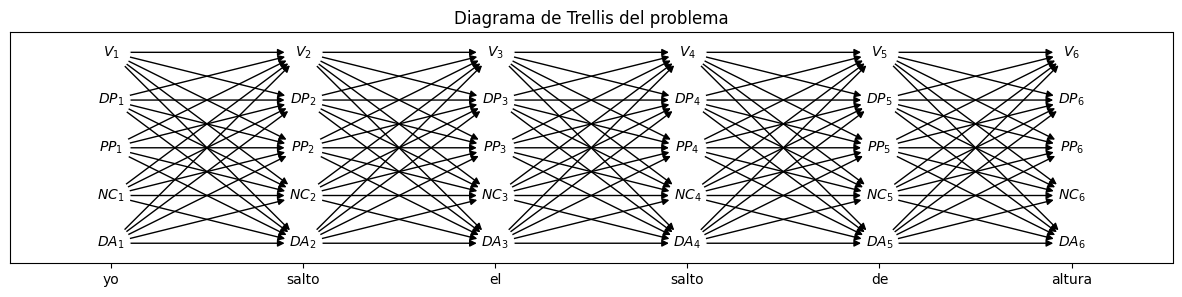

In [19]:
#Aristas
edges = []
#Posiciones
layout_all = {}
for t,w in enumerate(text1.split()):
    #Obtienes las aristas del diagrama Trellis
    for s in list(ems_voc.keys())[:-2]:
        for st in list(ems_voc.keys())[:-2]:
            prev = '$'+s+'_'+str(t+1)+'$'
            actual = '$'+st+'_'+str(t+1+1)+'$'
            layout_all[prev] = np.array([t, ems_voc[s]])
            if t < len(text1.split()) - 1:
                edges.append( (prev, actual) )
                layout_all[actual] = np.array([t+1, ems_voc[s]])
        

#Gráfica del diagrama
graph = nx.DiGraph()
graph.add_edges_from(edges)

#Visualización
fig, ax = plt.subplots(figsize=(15, 3))
nx.draw_networkx(graph, with_labels=True, node_size=700, font_size=10, node_color='#ffffff', pos=layout_all, ax=ax)
ax.tick_params(bottom=True, labelbottom=True)
plt.title('Diagrama de Trellis del problema')
#plt.xticks([0,1,2,3,4,5,6,7], text1.split())
plt.xticks(range(len(text1.split())), text1.split())
plt.show()

### Implementación del Algoritmo de Viterbi

Lo que busca el algoritmo de Viterbi es reducir el espacio de búsqueda a sólo aquellos caminos que sean los más probables en cada tiempo $t$. Para esto, se basa en dos pasos generales:

1. Forward (avance): En esta parte busca calcular las probabilidades y los caminos que tengan la mayor probabilidad para cada tiempo $t$ olvidando aquellos caminos que en este tiempo no maximicen la probabilidad. Al final se quedará con sólo $N$ caminos posibles.
2. Backward (retroceso): De los $N$ caminos posibles, elige al que tenga la mayor probabilidad total y recupera las emisiones correspondientes a este camino.

La salida del algoritmo será la secuencia de emisiones que maximiza la probabilidad de los $N$ caminos restantes durante el paso forward. Como señalamos, no se puede garantizar que el algoritmo de Viterbi llegue al máximo global, pero sí garantiza un máximo local, y en la mayoría de los casos funciona adecuadamente.


#### Forward

El paso forward define una variable $\delta_j(t)$, donde $j$ corresponde acada una de las $N$ valores que pueden tomar nuestras variables $Y_t$ en el tiempo $t$. Asimismo, define variables categóricas $\phi_j(t)$ que lo que hacen es guardar los caminos definidos por las probabilidades de las variables $\delta_j(t)$. El paso forward consiste en:

* <b>Inicialización</b>:  Inicializa los valores $\delta$ para cada $j$ correspondiente a los valores de emisión como: $$\delta_j(0) = p(x^{(0)}|y_j)p(y_j)$$ En términos de matrices $$\delta(0) = B_{x^{(0)}} \odot \Pi$$
* <b>Inducción</b>: Obtiene las probabilidades en cada tiempo $t$ quedándose sólo con aquellas que maximizan los valores, de igual forma lo hace para cada valor $j$: $$\delta_j(t+1) = \max_i p(x^{(t+1)}|y_j)p(y_j|y_i)\delta_i(t)$$ En términos de vectores y matrices: $$\delta(t+1) = \max_i A \odot \Big(B_{w^{(t+1)}} \otimes \delta(t) \Big)$$ Las variables $\phi$ se calculan de forma similar pero usando el $\arg\max$.

Podemos observar que lo que obtiene son las probabilidades en cada tiempo $t$ para $\delta$ de la siguiente forma:

$$\delta_j(t) = \max_{i_1,...,i_{t-1}} p(y_{i_1}^{(1)},..., y_{i_{t-1}}^{(t-1)}, x^{(1)},...,x^{(t)}, y^{(t)}_j)$$

Es decir, las variables $\delta$ guardan las probabilidades conjuntas para cada tiempo $t$, por lo que en el último paso $T$, tendremos $N$ variables $\delta_j$ cada una con una probabilidad conjunta. El caso de $\phi$ es similar:

$$\phi_j(t) = \arg\max_{i_1,...,i_{t-1}} p(y_{i_1}^{(1)},..., y_{i_{t-1}}^{(t-1)}, x^{(1)},...,x^{(t)}, y^{(t)}_j)$$

En este caso, lo que las variables $\phi_j$ guardan son los valores de los caminos que maximizan las probabilidades.

```python
def forward(obs, HMM):
    """Función de paso forward del algoritmo de Viterbi"""
```

Nuestra función forward tomará una secuencia de entrada a etiquetar y el modelo de Márkov y regresará las variables $\delta$ y $\phi$ para cada tiempo, recordemos que cada tiempo representa una observación de la entrada. Por tanto, podemos ver que las variables $\delta$ se pueden representar en una tabla con columnas que son las variables $y_i$ y con renglones que responden a las observaciones en cada tiempo $t$.

In [20]:
from viterbi_hmm import forward

In [21]:
%%time
#Obtenemos las observaciones por estado
obs_text = text1.split()

d, phi = forward(obs_text, (ems_voc, obs_voc, A, Pi, B))

pd.DataFrame(data=d, index=obs_text, columns=list(ems_voc.keys())[:-2])

CPU times: user 804 µs, sys: 520 µs, total: 1.32 ms
Wall time: 1.32 ms


,DA,NC,PP,DP,V
yo,1.111111e-02,8.771930e-03,6.410256e-03,9.375000e-02,5.208333e-03
salto,2.525253e-04,2.923977e-04,1.092657e-04,1.598011e-03,5.326705e-04
el,1.721763e-05,9.968102e-06,4.929281e-06,2.723883e-05,1.815922e-05
salto,3.913098e-07,9.968102e-07,9.858562e-08,5.447766e-07,6.190643e-07
de,2.668021e-08,3.398217e-08,4.447472e-09,9.285965e-09,2.110447e-08
altura,7.696215e-10,2.940764e-09,1.282925e-10,2.678644e-10,7.194704e-10


De igual forma, podemos visualizar las variables $\phi$, que como señalamos, marcan el camino en cada tiempo $t$, representado por un valor de entrada (palabra). Así, cada entrada de la tabla para las variables $\phi$ representa el valor anterior más probables para llegar al valor actual $y_i$ representado en la columna de la tabla.

In [22]:
phi_cat = []
for j, c in enumerate(phi):
    phi_cat.append([tags[i] for i in c])
    
pd.DataFrame(data=phi_cat, index=obs_text, columns=list(ems_voc.keys())[:-2])

,DA,NC,PP,DP,V
yo,V,DA,DP,DP,DP
salto,V,V,NC,V,DP
el,V,DA,DA,DA,DP
salto,V,V,NC,V,DP
de,PP,PP,PP,PP,DP
altura,DA,DA,DA,DA,DA


Lo que esta parte del algoritmo ha hecho es crear una gráfica con $N$ caminos, tantos como símbolos de emisión. De esta forma, la complejidad de la búsqueda se simplifica. Podemos observar cómo se comportan los caminos encontrados.

In [23]:
trellis = []
#Creamos las transiciones que se dan con Viterbi
for i, w in enumerate(obs_text):
    print(w)
    for s,j in ems_voc.items():
        try:
            if i != len(obs_text)-1:
                print('\t', phi_cat[i][j], '-->', s, d[i][j])
                trellis.append(('$'+phi_cat[i][j]+'_'+str(i+1)+'$', '$'+s+'_'+str(i+2)+'$', d[i][j]))
            else:
                print('\t', s, d[i][j],)
        except:
            pass

yo
	 V --> DA 0.01111111111111111
	 DA --> NC 0.008771929824561403
	 DP --> PP 0.00641025641025641
	 DP --> DP 0.09375
	 DP --> V 0.005208333333333333
salto
	 V --> DA 0.0002525252525252525
	 V --> NC 0.00029239766081871346
	 NC --> PP 0.00010926573426573428
	 V --> DP 0.0015980113636363637
	 DP --> V 0.0005326704545454545
el
	 V --> DA 1.7217630853994492e-05
	 DA --> NC 9.968102073365231e-06
	 DA --> PP 4.929281245070719e-06
	 DA --> DP 2.7238830061983472e-05
	 DP --> V 1.815922004132231e-05
salto
	 V --> DA 3.913097921362385e-07
	 V --> NC 9.968102073365232e-07
	 NC --> PP 9.858562490141437e-08
	 V --> DP 5.447766012396696e-07
	 DP --> V 6.190643195905332e-07
de
	 PP --> DA 2.668021310019808e-08
	 PP --> NC 3.3982166159199657e-08
	 PP --> PP 4.447471800063806e-09
	 PP --> DP 9.285964793858004e-09
	 DP --> V 2.110446544058636e-08
altura
	 DA 7.696215317364832e-10
	 NC 2.9407643791615087e-09
	 PP 1.2829245577107133e-10
	 DP 2.6786436905359626e-10
	 V 7.194704127472622e-10


Una forma más clara de verlo es a partir del diagrama de caminos que resultan de aplicar el algoritmo de Viterbi. Tenemos tantos caminos como símbolos. Sólo basta escoger un camino que maximice la probabilidad para obtener la cadena de emisiones más óptima.

En el nuevo diagrama obtenido, vemos que el número de caminos se ha simplificado bastante. Ya no hay $O(N^{T})$ caminos, pues el algoritmo de Viterbi sólo toma un camino por valor en cada tiempo. Podemos ver que en la fase inicial considerara $N$ valores. Pero en el siguiente paso, para cada valor $y_i$ tomará sólo el camino previo más probable para cada valor actual. Entonces comparará $N$ símbolos actuales con los $N$ símbolos previos, teniendo un total de $N^2$ operaciones. Esto lo hará para cada tiempo. Por lo que en total sólo tendremos $T N^2$ operaciones en total, reduciendo la complejidad a una complejidad cuadrática.

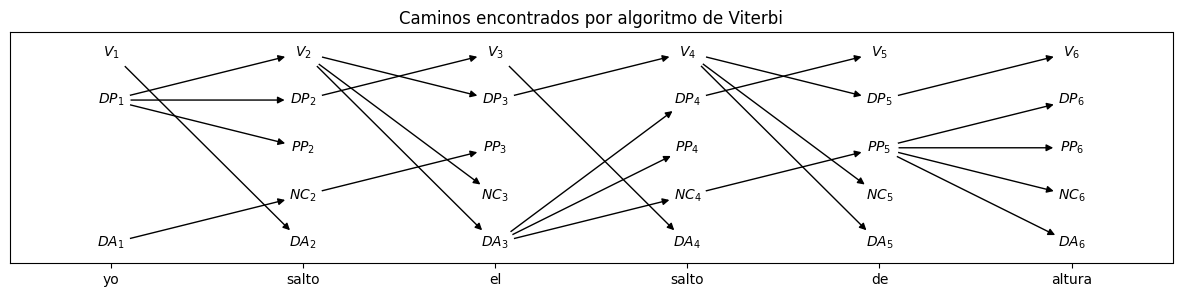

In [24]:
#Crea el diagrama Trellis
Trell = nx.DiGraph()
Trell.add_weighted_edges_from(trellis)

#Posiciona los nodos
layout = {}
for n in Trell.nodes:
    lab, t = n.split('_')
    layout[n] = np.array([float(t[:1])-1, ems_voc[lab[1:]]])

#Visualización
fig, ax = plt.subplots(figsize=(15, 3))
nx.draw_networkx(Trell, with_labels=True, node_size=700, font_size=10, node_color='#ffffff', pos=layout, ax=ax)
ax.tick_params(bottom=True, labelbottom=True)
plt.title('Caminos encontrados por algoritmo de Viterbi')
#plt.xticks([0,1,2,3,4,5,6,7], obs_text)
plt.xticks(range(len(text1.split())), text1.split())
plt.show()

#### Backward

El paso backward se basará en la salida del paso forward, pues lo que hará es recuperar el camino, de los caminos obtenidos en el forward, que maximice la probabilidad total. De esta forma, lo único que hace es encontrar el camino con mayor probabilidad y recuperar los valores que le corresponden. Este algoritmo entonces se basará en:


* <b>Inicialización</b>: Encuentra el camino que tiene la mayor probabilidad total y recupera el último símbolo de este camino como: $$\hat{y}^{(T)} = \arg\max_i \delta_i(T)$$
* <b>Inducción</b>: Recupera el valor previo en el camino elegido en la inicialización de la forma: $$\hat{y}^{(t)} = \phi_{\hat{y}^{(t+1)}}(t+1)$$

Como podemos observar, la inicialización busca la probabilidad más alta en las variables $\delta_i(T)$ y la inducción recupera el camino con las variables $\phi$. El camino lo recupera de manera inversa, pues empieza del último valor y de allí recorre hacia atrás (de allí el nombre backward) hasta el primer símbolo. Por lo que la secuencia debe ser invertida para obtener la secuencia real.

```python
def backward(d,phi):
    """Función backward para el algoritmo de Viterbi"""
```

In [25]:
from viterbi_hmm import backward

Como hemos trabajado con valores enteros que indexan a las etiquetas gramaticales, necesitamos recuperar los valores de etiquetas que corresponden a estos índices. Para hacer esto, definiremos una función que implementa el algoritmo de Viterbi aplicando el forward y el backward:

In [26]:
def Viterbi(obs_text, HMM):
    """Algoritmo de Viterbi"""
    #Obtiene el HMM
    ems_voc, obs_voc, A, Pi, B = HMM
    #Forward
    d,phi = forward(obs_text, (ems_voc, obs_voc, A, Pi, B))
    #Backward
    tags_idx = backward(d,phi)
    
    #Recupera los tags de los índices
    tags = {value:key for key, value in ems_voc.items()}
    output = [tags[yt] for yt in tags_idx]
    
    print( 'Input:\t{}\nOutput:\t{}'.format('\t'.join(obs_text), '\t'.join(output)) ) 
    
    return output
    
Viterbi(obs_text, (ems_voc, obs_voc, A, Pi, B))

Input:	yo	salto	el	salto	de	altura
Output:	DP	V	DA	NC	PP	NC


['DP', 'V', 'DA', 'NC', 'PP', 'NC']

Como podemos observar, las etiquetas elegidas para esta cadena son correctas. En este caso, el algoritmo de Viterbi nos ha llevado a encontrar el máximo global, y coincide con el resultado obtenido con fuerza bruta, pero es mucho más eficiente.